In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import wandb
import numpy as np
import torch
import pandas as pd
import evaluate
import ast
from sklearn.metrics import PrecisionRecallDisplay
from IPython.utils import io

In [15]:
api = wandb.Api()

In [16]:
def download_predictions(run_name: str) -> tuple[dict]:
    ret = []

    wandb_project_base = 'redstag/thesis'
    api = wandb.Api()
    runs = api.runs(path=wandb_project_base, filters={"display_name": run_name})

    for run in runs:
        if run.state == 'finished':
            for art in run.logged_artifacts():
                if "predictions" in art.name:
                    path = art.download()
                    labels = np.load(path + '/labels.npy')
                    predictions = np.load(path + '/predictions.npy')
                    # Apply softmax to prediction logits using torch
                    predictions_t = torch.tensor(predictions)
                    probs = torch.nn.functional.softmax(predictions_t, dim=-1)
                    predictions = torch.argmax(probs, dim=1, keepdim=True).flatten().numpy()

                    ret.append({
                        'run_name': run_name,
                        'artifact_name': art.name,
                        'predictions': predictions,
                        'probs': probs[:,1].flatten(),
                        'labels': labels})
    
    return tuple(ret)

In [17]:
def get_logged_f1(run_name: str) -> np.array:
    wandb_project_base = 'redstag/thesis'
    api = wandb.Api()
    runs = api.runs(path=wandb_project_base, filters={"display_name": run_name})
    f1s = []

    for run in runs:
        if "test/f1" in run.summary:
            f1s.append(run.summary["test/f1"])
    
    return np.array(f1s)

In [18]:
def plot_predictions(predictions: dict):
    conf_mats = [confusion_matrix(preds["labels"], preds["predictions"]) for preds in predictions]
    fig, axes = plt.subplots(1, len(conf_mats), figsize=(15, 5))
    fig.suptitle(predictions[0]["run_name"], fontsize=16)

    if len(conf_mats) == 1:
        # Wrap in array if single axes so we can iter
        axes = [axes]

    for ax, cm, preds in zip(axes, conf_mats, predictions):
        disp = ConfusionMatrixDisplay(cm)
        disp.plot(ax=ax)
        ax.title.set_text(preds['artifact_name'])

    plt.tight_layout()
    plt.show()

In [19]:
def calculate_metrics(predictions: dict, invert: bool):
    metric = evaluate.combine(["precision", "recall", "accuracy", "f1"])

    if invert:
        metrics = [metric.compute(predictions=np.abs(preds["predictions"] - 1), references=np.abs(preds["labels"] - 1)) for preds in predictions]
    else:
        metrics = [metric.compute(predictions=preds["predictions"], references=preds["labels"]) for preds in predictions]
    
    return pd.DataFrame(metrics)

In [20]:
def get_misclassified_samples(predictions: np.array, data_frame: pd.DataFrame, trunc_data: int | bool = False):
    if trunc_data:
        data_frame = data_frame.head(trunc_data)
    
    # Convert the "class_label" column to integers (Yes -> 1, No -> 0)
    data_frame['class_label'] = data_frame['class_label'].map({'Yes': 1, 'No': 0})
    
    # Retrieve rows where the "class_label" column does not match the predictions
    misclassified_samples = data_frame[data_frame['class_label'] != predictions]
    
    return misclassified_samples

In [21]:
def plot_misclassifications(misclassified: pd.DataFrame, plot_header: str | None = None):
    columns_to_plot = ["topic", "style", "source", "class_label", "sentiment"]

    fig, axes = plt.subplots(2, 3, figsize=(8, 6))

    if plot_header:
        fig.suptitle(plot_header, fontsize=16)

    axes = axes.flatten()

    for idx, col in enumerate(columns_to_plot):
        misclassified[col].value_counts().plot(kind='bar', ax=axes[idx], title=f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
    
    # Handle NER
    ner_counts = {}
    for tags in misclassified['ner'].dropna():
        for t in tags:
            if t in ner_counts:
                ner_counts[t] += 1
            else:
                ner_counts[t] = 1
    
    # Plot NER tag distribution as a histogram in the last subplot
    plt.tight_layout()
    plt.show()

    # Plot NER tag distribution in a separate figure
    if ner_counts:
        # Sort ner_counts by descending value
        sorted_ner = sorted(ner_counts.items(), key=lambda x: x[1], reverse=True)
        ner_tags, ner_values = zip(*sorted_ner)
        plt.figure(figsize=(6, 4))
        plt.bar(ner_tags, ner_values)
        plt.title('NER Tag Distribution')
        plt.xlabel('NER Tag')
        plt.ylabel('Count')
        plt.xticks(rotation=60)
        plt.tight_layout()
        plt.show()
    

    plt.tight_layout()
    plt.show()

In [22]:
from collections import Counter

def intersect_misclassifications(misclassified: list[pd.DataFrame], min_num_misclassified: int) -> pd.DataFrame:
    # Combine all misclassified dataframes into a single dataframe
    combined = pd.concat(misclassified, ignore_index=True)
    
    # Count occurrences of each Sentence_id across all dataframes
    counts = combined['Sentence_id'].value_counts()
    
    # Filter Sentence_ids that appear in at least min_num_misclassified dataframes
    frequent_ids = counts[counts >= min_num_misclassified].index
    
    # Retrieve rows with those Sentence_ids
    result = combined[combined['Sentence_id'].isin(frequent_ids)]

    # Remove duplicate rows based on 'Sentence_id', keeping the first occurrence
    result = result.drop_duplicates(subset='Sentence_id')
    
    return result

def exclusive_misclassifications(misclassified_left: pd.DataFrame, misclassified_right: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    intersection = intersect_misclassifications([misclassified_left, misclassified_right], min_num_misclassified=2)
    exclusive_left = misclassified_left[~misclassified_left['Sentence_id'].isin(intersection['Sentence_id'])]
    exclusive_right = misclassified_right[~misclassified_right['Sentence_id'].isin(intersection['Sentence_id'])]
    
    return exclusive_left, exclusive_right

In [23]:
def strip_plot_f1(title: str, metric_data: dict, metric_name: str):
    """
    Plot a strip plot of F1 scores for various datasets.

    Args:
        title (str): Title of the plot.
        metric_data (dict): Dictionary where keys are dataset names (str) and
                        values are numpy arrays of metric scores (float).
    """
    datasets = list(metric_data.keys())
    fig, ax = plt.subplots(figsize=(7, 1 + len(datasets) * 0.3))
    
    # Use a single color for all dots
    dot_color = 'tab:blue'
    for i, dataset in enumerate(datasets):
        y_vals = np.full_like(metric_data[dataset], fill_value=i, dtype=float)
        run_scatter = ax.scatter(metric_data[dataset], y_vals, s=30, color=dot_color, alpha=0.5)
        # Plot the mean F1 score as a smaller dot
        mean_f1 = np.mean(metric_data[dataset])
        mean_scatter = ax.scatter(mean_f1, i, s=60, color='orange', marker='+')

        # Add legend
        if i == 0:
            ax.legend([run_scatter, mean_scatter], ["Single run", "Mean"])

    all_f1 = np.concatenate(list(metric_data.values()))
    min_f1 = np.min(all_f1)
    max_f1 = np.max(all_f1)
    x_start = max(0, min_f1 - 0.05)
    x_end = min(1, max_f1 + 0.05)

    ax.set_yticks(np.arange(len(datasets)))
    ax.set_yticklabels(datasets)
    ax.set_xlabel(metric_name.capitalize())
    ax.set_ylabel("Dataset")
    ax.set_xlim(x_start, x_end)
    ax.set_title(title)
    ax.invert_yaxis()  # Optional: to match visual style
    plt.grid(axis='both', linestyle='--', alpha=0.85)
    plt.tight_layout()
    plt.show()

In [24]:
def plot_precision_recall(title: str, predictions: dict[tuple[dict[str, np.array]]]):
    """
    Plot precision recall curves for different dataset mixes.

    Args:
    title (str): Title of the plot.
    predictions (dict): Dictionary where keys are dataset names (str) and
                    values are tuples of dicts with keys "labels" and "predictions" and np.array values.
    """

    for dataset, runs in predictions.items():
        preds = runs[0]
        display = PrecisionRecallDisplay.from_predictions(
            preds["labels"], preds["probs"], name=dataset, plot_chance_level=True, despine=True
        )
        _ = display.ax_.set_title(title)

In [27]:
def runs_to_f1_stripplots(groups: list[dict], invert: bool = False):
    """
    Given a list containing dicts of eval groups creates a strip plot of f1 performance for each sub-list

    Args:
    groups (list): Contains a dict with keys "runs", containing run names and "title" containing the plot title.
    """
    metric_name = "f1 (negative class)" if invert else "f1"
    strip_plots = []

    for group in groups:
        runs = group["runs"]
        predictions = [download_predictions(r) for r in runs]
        metrics = [calculate_metrics(p, invert=invert) for p in predictions]

        if "strip_suffix" in group:
            strip_plots.append({"plot": {r.replace(group["strip_suffix"], ""): m["f1"] for r, m in zip(runs, metrics)}, "title": group["title"]})
        else:
            strip_plots.append({"plot": {r: m["f1"] for r, m in zip(runs, metrics)}, "title": group["title"]})

    for strip_plot in strip_plots:
        strip_plot_f1(strip_plot["title"], strip_plot["plot"], metric_name)


wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downlo

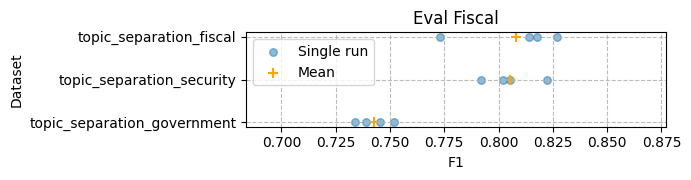

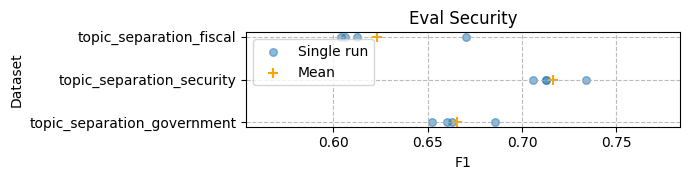

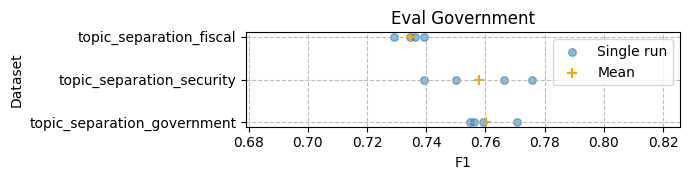

In [35]:
eval_groups = [
    # {
    #     "runs": [
    #         "ct24_synth_10k_0_gc_fact_check_pos_eval",
    #         "ct24_synth_8k_2k_gc_fact_check_pos_eval",
    #         "ct24_synth_6k_4k_gc_fact_check_pos_eval",
    #         "ct24_synth_4k_6k_gc_fact_check_pos_eval",
    #         "ct24_synth_2k_8k_gc_fact_check_pos_eval",
    #         "ct24_synth_0_10k_gc_fact_check_pos_eval"
    #     ],
    #     "strip_suffix": "_gc_fact_check_pos_eval",
    #     "title": "Train CT24/Synthetic - Eval GC (Source - Fact Checks [Pos])"
    # },
    # {
    #     "runs": [
    #         "ct24_synth_10k_0_viclaim_eval",
    #         "ct24_synth_8k_2k_viclaim_eval",
    #         "ct24_synth_6k_4k_viclaim_eval",
    #         "ct24_synth_4k_6k_viclaim_eval",
    #         "ct24_synth_2k_8k_viclaim_eval",
    #         "ct24_synth_0_10k_viclaim_eval",
    #     ],
    #     "strip_suffix": "_viclaim_eval",
    #     "title": "Train CT24/Synthetic - Eval ViClaim"
    # },
    # {
    #     "runs": [
    #         "topic_split_1_topic_split_1_eval"
    #     ],
    #     "strip_suffix": "_topic_split_1_eval",
    #     "title": "Train Split 1 - Eval Split 1"
    # },
    # {
    #     "runs": [
    #         "topic_split_1_topic_split_2_eval"
    #     ],
    #     "strip_suffix": "_topic_split_2_eval",
    #     "title": "Train Split 1 - Eval Split 2"
    # },
    # {
    #     "runs": [
    #         "topic_split_2_topic_split_2_eval"
    #     ],
    #     "strip_suffix": "_topic_split_2_eval",
    #     "title": "Train Split 2 - Eval Split 2"
    # },
    # {
    #     "runs": [
    #         "topic_split_2_topic_split_1_eval"
    #     ],
    #     "strip_suffix": "_topic_split_1_eval",
    #     "title": "Train Split 2 - Eval Split 1"
    # },
    {
        "runs": [
            "topic_separation_fiscal_topic_separation_fiscal_eval",
            "topic_separation_security_topic_separation_fiscal_eval",
            "topic_separation_government_topic_separation_fiscal_eval"
        ],
        "strip_suffix": "_topic_separation_fiscal_eval",
        "title": "Eval Fiscal"
    },
    {
        "runs": [
            "topic_separation_fiscal_topic_separation_security_eval",
            "topic_separation_security_topic_separation_security_eval",
            "topic_separation_government_topic_separation_security_eval"
        ],
        "strip_suffix": "_topic_separation_security_eval",
        "title": "Eval Security"
    },
    {
        "runs": [
            "topic_separation_fiscal_topic_separation_government_eval",
            "topic_separation_security_topic_separation_government_eval",
            "topic_separation_government_topic_separation_government_eval"
        ],
        "strip_suffix": "_topic_separation_government_eval",
        "title": "Eval Government"
    },
    # {
    #     "runs": [
    #         "ct24_synth_10k_0_gc_source_microtext_eval",
    #         "ct24_synth_8k_2k_gc_source_microtext_eval",
    #         "ct24_synth_6k_4k_gc_source_microtext_eval",
    #         "ct24_synth_4k_6k_gc_source_microtext_eval",
    #         "ct24_synth_2k_8k_gc_source_microtext_eval",
    #         "ct24_synth_0_10k_gc_source_microtext_eval"
    #     ],
    #     "strip_suffix": "_gc_source_microtext_eval",
    #     "title": "Train CT24/Synthetic - Eval GC (Source - Microtext)"
    # },
    # {
    #     "runs": [
    #         "ct24_synth_10k_0_gc_source_various_eval",
    #         "ct24_synth_8k_2k_gc_source_various_eval",
    #         "ct24_synth_6k_4k_gc_source_various_eval",
    #         "ct24_synth_4k_6k_gc_source_various_eval",
    #         "ct24_synth_2k_8k_gc_source_various_eval",
    #         "ct24_synth_0_10k_gc_source_various_eval"
    #     ],
    #     "strip_suffix": "_gc_source_various_eval",
    #     "title": "Train CT24/Synthetic - Eval GC (Source - Various)"
    # },
    # {
    #     "runs": [
    #         "ct24_synth_10k_0_gc_source_essay_eval",
    #         "ct24_synth_8k_2k_gc_source_essay_eval",
    #         "ct24_synth_6k_4k_gc_source_essay_eval",
    #         "ct24_synth_4k_6k_gc_source_essay_eval",
    #         "ct24_synth_2k_8k_gc_source_essay_eval",
    #         "ct24_synth_0_10k_gc_source_essay_eval"
    #     ],
    #     "strip_suffix": "_gc_source_essay_eval",
    #     "title": "Train CT24/Synthetic - Eval GC (Source - Essay)"
    # },
    # {
    #     "runs": [
    #         "ct24_synth_10k_0_gc_source_livejournal_eval",
    #         "ct24_synth_8k_2k_gc_source_livejournal_eval",
    #         "ct24_synth_6k_4k_gc_source_livejournal_eval",
    #         "ct24_synth_4k_6k_gc_source_livejournal_eval",
    #         "ct24_synth_2k_8k_gc_source_livejournal_eval",
    #         "ct24_synth_0_10k_gc_source_livejournal_eval"
    #     ],
    #     "strip_suffix": "_gc_source_livejournal_eval",
    #     "title": "Train CT24/Synthetic - Eval GC (Source - Live Journal)"
    # },
    # {
    #     "runs": [
    #         "ct24_synth_10k_0_gc_source_wiki_eval",
    #         "ct24_synth_8k_2k_gc_source_wiki_eval",
    #         "ct24_synth_6k_4k_gc_source_wiki_eval",
    #         "ct24_synth_4k_6k_gc_source_wiki_eval",
    #         "ct24_synth_2k_8k_gc_source_wiki_eval",
    #         "ct24_synth_0_10k_gc_source_wiki_eval"
    #     ],
    #     "strip_suffix": "_gc_source_wiki_eval",
    #     "title": "Train CT24/Synthetic - Eval GC (Source - Wiki)"
    # },
    # {
    #     "runs": [
    #         "ct24_synth_10k_0_gc_topic_various_eval",
    #         "ct24_synth_8k_2k_gc_topic_various_eval",
    #         "ct24_synth_6k_4k_gc_topic_various_eval",
    #         "ct24_synth_4k_6k_gc_topic_various_eval",
    #         "ct24_synth_2k_8k_gc_topic_various_eval",
    #         "ct24_synth_0_10k_gc_topic_various_eval"
    #     ],
    #     "strip_suffix": "_gc_topic_various_eval",
    #     "title": "Train CT24/Synthetic - Eval GC (Topic - Various)"
    # },
    # {
    #     "runs": [
    #         "ct24_synth_10k_0_gc_topic_politics_eval",
    #         "ct24_synth_8k_2k_gc_topic_politics_eval",
    #         "ct24_synth_6k_4k_gc_topic_politics_eval",
    #         "ct24_synth_4k_6k_gc_topic_politics_eval",
    #         "ct24_synth_2k_8k_gc_topic_politics_eval",
    #         "ct24_synth_0_10k_gc_topic_politics_eval"
    #     ],
    #     "strip_suffix": "_gc_topic_politics_eval",
    #     "title": "Train CT24/Synthetic - Eval GC (Topic - Politics)"
    # },
    #     {
    #     "runs": [
    #         "ct24_synth_10k_0_gc_style_semi_eval",
    #         "ct24_synth_8k_2k_gc_style_semi_eval",
    #         "ct24_synth_6k_4k_gc_style_semi_eval",
    #         "ct24_synth_4k_6k_gc_style_semi_eval",
    #         "ct24_synth_2k_8k_gc_style_semi_eval",
    #         "ct24_synth_0_10k_gc_style_semi_eval"
    #     ],
    #     "strip_suffix": "_gc_style_semi_eval",
    #     "title": "Train CT24/Synthetic - Eval GC (Style - Semi)"
    # },
    #     {
    #     "runs": [
    #         "ct24_synth_10k_0_gc_style_structured_eval",
    #         "ct24_synth_8k_2k_gc_style_structured_eval",
    #         "ct24_synth_6k_4k_gc_style_structured_eval",
    #         "ct24_synth_4k_6k_gc_style_structured_eval",
    #         "ct24_synth_2k_8k_gc_style_structured_eval",
    #         "ct24_synth_0_10k_gc_style_structured_eval"
    #     ],
    #     "strip_suffix": "_gc_style_structured_eval",
    #     "title": "Train CT24/Synthetic - Eval GC (Style - Structured)"
    # },
]
runs_to_f1_stripplots(eval_groups)

In [13]:
# ct24_train_ct21_ct22_eval_datasets = [
#     "ct24_synth_10k_0_ct21_ct22_eval",
#     "ct24_synth_8k_2k_ct21_ct22_eval",
#     "ct24_synth_6k_4k_ct21_ct22_eval",
#     "ct24_synth_4k_6k_ct21_ct22_eval",
#     "ct24_synth_2k_8k_ct21_ct22_eval",
#     "ct24_synth_0_10k_ct21_ct22_eval",
#     ]

# ct24_train_gc_eval_datasets = [
#     "ct24_synth_10k_0_gc_eval",
#     "ct24_synth_8k_2k_gc_eval",
#     "ct24_synth_6k_4k_gc_eval",
#     "ct24_synth_4k_6k_gc_eval",
#     "ct24_synth_2k_8k_gc_eval",
#     "ct24_synth_0_10k_gc_eval",
#     ]

# ct24_train_eval_datasets = [
#     "ct24_synth_10k_0_ct24_eval",
#     "ct24_synth_8k_2k_ct24_eval",
#     "ct24_synth_6k_4k_ct24_eval",
#     "ct24_synth_4k_6k_ct24_eval",
#     "ct24_synth_2k_8k_ct24_eval",
#     "ct24_synth_0_10k_ct24_eval",
#     ]

# gc_train_eval_datasets = [
#     "gc_synth_10k_0_gc_eval",
#     "gc_synth_8k_2k_gc_eval",
#     "gc_synth_6k_4k_gc_eval",
#     "gc_synth_4k_6k_gc_eval",
#     "gc_synth_2k_8k_gc_eval",
#     "gc_synth_0_10k_gc_eval",
#     ]

# gc_train_ct24_eval_datasets = [
#     "gc_synth_10k_0_ct24_eval",
#     "gc_synth_8k_2k_ct24_eval",
#     "gc_synth_6k_4k_ct24_eval",
#     "gc_synth_4k_6k_ct24_eval",
#     "gc_synth_2k_8k_ct24_eval",
#     "gc_synth_0_10k_ct24_eval",
# ]

# ct24_train_synth_eval_datasets = [
#     "ct24_synth_10k_0_synth_eval",
#     "ct24_synth_8k_2k_synth_eval",
#     "ct24_synth_6k_4k_synth_eval",
#     "ct24_synth_4k_6k_synth_eval",
#     "ct24_synth_2k_8k_synth_eval",
#     "ct24_synth_0_10k_synth_eval",
# ]

# gc_train_synth_eval_datasets = [
#     "gc_synth_10k_0_synth_eval",
#     "gc_synth_8k_2k_synth_eval",
#     "gc_synth_6k_4k_synth_eval",
#     "gc_synth_4k_6k_synth_eval",
#     "gc_synth_2k_8k_synth_eval",
#     "gc_synth_0_10k_synth_eval",
# ]

# ct24_train_gold_eval_datasets = [
#     "ct24_synth_10k_0_ct24_gold_eval",
#     #"ct24_synth_9k_1k_ct24_gold_eval",
#     "ct24_synth_8k_2k_ct24_gold_eval",
#     #"ct24_synth_7k_3k_ct24_gold_eval",
#     "ct24_synth_6k_4k_ct24_gold_eval",
#     "ct24_synth_4k_6k_ct24_gold_eval",
#     "ct24_synth_2k_8k_ct24_gold_eval",
#     "ct24_synth_0_10k_ct24_gold_eval",
#     ]

# gc_train_ct24_gold_eval_datasets = [
#     "gc_synth_10k_0_ct24_gold_eval",
#     "gc_synth_8k_2k_ct24_gold_eval",
#     "gc_synth_6k_4k_ct24_gold_eval",
#     "gc_synth_4k_6k_ct24_gold_eval",
#     "gc_synth_2k_8k_ct24_gold_eval",
#     "gc_synth_0_10k_ct24_gold_eval",
#     ]

# ct24_train_synth_variants_eval_datasets = [
#     "ct24_synth_10k_0_gpt_4o_eval",
#     "ct24_synth_10k_0_gpt_4_1_eval",
#     "ct24_synth_10k_0_o3_mini_eval",
#     "ct24_synth_10k_0_o4_mini_eval",
# ]

# ct24_train_synth_mix_gc_eval_datasets = [
#     "ct24_synth_mix_8k_2k_gc_eval",
# ]

# topic_split_1_topic_split_1_eval_datasets = [
#     "topic_split_1_topic_split_1_eval"
# ]
# topic_split_1_topic_split_2_eval_datasets = [
#     "topic_split_1_topic_split_2_eval"
# ]
# topic_split_2_topic_split_1_eval_datasets = [
#     "topic_split_2_topic_split_1_eval"
# ]
# topic_split_2_topic_split_2_eval_datasets = [
#     "topic_split_2_topic_split_2_eval"
# ]

# ct24_synth_corona_train_ct24_eval = [
#     "ct24_synth_corona_2.6k_0k",
#     "ct24_synth_corona_2.1k_0.5k",
#     "ct24_synth_corona_1.6k_1.0k",
#     "ct24_synth_corona_1.0k_1.6k",
#     "ct24_synth_corona_0.5k_2.1k",
#     "ct24_synth_corona_0k_2.6k",
# ]

# ct24_synth_corona_train_ct21_ct22_eval = [
#     "ct24_synth_corona_2.6k_0k_ct21_ct22_eval",
#     "ct24_synth_corona_2.1k_0.5k_ct21_ct22_eval",
#     "ct24_synth_corona_1.6k_1.0k_ct21_ct22_eval",
#     "ct24_synth_corona_1.0k_1.6k_ct21_ct22_eval",
#     "ct24_synth_corona_0.5k_2.1k_ct21_ct22_eval",
#     "ct24_synth_corona_0k_2.6k_ct21_ct22_eval",
# ]

# ct21_ct22_synth_train_ct24_eval = [
#     "ct21_ct22_synth_2.6k_0k_ct24_eval",
#     "ct21_ct22_synth_2.1k_0.5k_ct24_eval",
#     "ct21_ct22_synth_1.6k_1.0k_ct24_eval",
#     "ct21_ct22_synth_1.0k_1.6k_ct24_eval",
#     "ct21_ct22_synth_0.5k_2.1k_ct24_eval",
#     "ct21_ct22_synth_0k_2.6k_ct24_eval",
# ]

# ct21_ct22_synth_train_ct21_ct22_eval = [
#     "ct21_ct22_synth_2.6k_0k",
#     "ct21_ct22_synth_2.1k_0.5k",
#     "ct21_ct22_synth_1.6k_1.0k",
#     "ct21_ct22_synth_1.0k_1.6k",
#     "ct21_ct22_synth_0.5k_2.1k",
#     "ct21_ct22_synth_0k_2.6k",
# ]

# ct24_synth_viclaim_eval = [
#     "ct24_synth_10k_0_viclaim_eval",
#     "ct24_synth_8k_2k_viclaim_eval",
#     "ct24_synth_6k_4k_viclaim_eval",
#     "ct24_synth_4k_6k_viclaim_eval",
#     "ct24_synth_2k_8k_viclaim_eval",
#     "ct24_synth_0_10k_viclaim_eval",
# ]


In [14]:
# predictions_ct24_gc = [download_predictions(d) for d in ct24_train_gc_eval_datasets]
# predictions_ct24_ct21_ct22 = [download_predictions(d) for d in ct24_train_ct21_ct22_eval_datasets]
# predictions_gc_ct24 = [download_predictions(d) for d in gc_train_ct24_eval_datasets]
# predictions_ct24_ct24 = [download_predictions(d) for d in ct24_train_eval_datasets]
# predictions_gc_gc = [download_predictions(d) for d in gc_train_eval_datasets]
# predictions_gc_synth = [download_predictions(d) for d in gc_train_synth_eval_datasets]
# predictions_ct24_synth = [download_predictions(d) for d in ct24_train_synth_eval_datasets]
# predictions_ct24_gold = [download_predictions(d) for d in ct24_train_gold_eval_datasets]
# predictions_gc_ct24_gold = [download_predictions(d) for d in gc_train_ct24_gold_eval_datasets]
# predictions_ct24_synth_variants = [download_predictions(d) for d in ct24_train_synth_variants_eval_datasets]
# predictions_ct24_synth_mix = [download_predictions(d) for d in ct24_train_synth_mix_gc_eval_datasets]
# predictions_t1_t1 = [download_predictions(d) for d in topic_split_1_topic_split_1_eval_datasets]
# predictions_t1_t2 = [download_predictions(d) for d in topic_split_1_topic_split_2_eval_datasets]
# predictions_t2_t1 = [download_predictions(d) for d in topic_split_2_topic_split_1_eval_datasets]
# predictions_t2_t2 = [download_predictions(d) for d in topic_split_2_topic_split_2_eval_datasets]
# predictions_ct24_corona_ct24 = [download_predictions(d) for d in ct24_synth_corona_train_ct24_eval]
# predictions_ct24_corona_ct2122 = [download_predictions(d) for d in ct24_synth_corona_train_ct21_ct22_eval]
# predictions_ct2122_ct2122 = [download_predictions(d) for d in ct21_ct22_synth_train_ct21_ct22_eval]
# predictions_ct2122_ct24 = [download_predictions(d) for d in ct21_ct22_synth_train_ct24_eval]
# predictions_ct24_viclaim = [download_predictions(d) for d in ct24_synth_viclaim_eval]

In [15]:
invert = False
# metrics_ct24_gc = [calculate_metrics(p, invert=invert) for p in predictions_ct24_gc]
# metrics_ct24_ct21_ct22 = [calculate_metrics(p, invert=invert) for p in predictions_ct24_ct21_ct22]
# metrics_gc_ct24 = [calculate_metrics(p, invert=invert) for p in predictions_gc_ct24]
# metrics_ct24_ct24 = [calculate_metrics(p, invert=invert) for p in predictions_ct24_ct24]
# metrics_gc_gc = [calculate_metrics(p, invert=invert) for p in predictions_gc_gc]
# metrics_ct24_synth = [calculate_metrics(p, invert=invert) for p in predictions_ct24_synth]
# metrics_gc_synth = [calculate_metrics(p, invert=invert) for p in predictions_gc_synth]
# metrics_ct24_gold = [calculate_metrics(p, invert=invert) for p in predictions_ct24_gold]
# metrics_gc_ct24_gold = [calculate_metrics(p, invert=invert) for p in predictions_gc_ct24_gold]
# metrics_ct24_synth_variants = [calculate_metrics(p, invert=invert) for p in predictions_ct24_synth_variants]
# metrics_t1_t1 = [calculate_metrics(p, invert=invert) for p in predictions_t1_t1]
# metrics_t1_t2 = [calculate_metrics(p, invert=invert) for p in predictions_t1_t2]
# metrics_t2_t1 = [calculate_metrics(p, invert=invert) for p in predictions_t2_t1]
# metrics_t2_t2 = [calculate_metrics(p, invert=invert) for p in predictions_t2_t2]
# metrics_ct24_ct24 = [calculate_metrics(p, invert=invert) for p in predictions_ct24_corona_ct24]
# metrics_ct24_ct21 = [calculate_metrics(p, invert=invert) for p in predictions_ct24_corona_ct2122]
# metrics_ct21_ct24 = [calculate_metrics(p, invert=invert) for p in predictions_ct2122_ct24]
# metrics_ct21_ct21 = [calculate_metrics(p, invert=invert) for p in predictions_ct2122_ct2122]
# metrics_ct24_viclaim = [calculate_metrics(p, invert=invert) for p in predictions_ct24_viclaim]

In [16]:
# for p, m in zip(predictions, metrics):
#     plot_predictions(p)
#     print(m)
#     print("--mean--")
#     print(m.mean())

In [17]:
metric = "f1"
# # Train on CT24 - Eval on GC
# strip_plot_ct24_train_gc_eval_data = {d.replace("_gc_eval", ""): m[metric] for d, m in zip(ct24_train_gc_eval_datasets, metrics_ct24_gc)}

# # Train on CT24 - Eval on CT21/22
# strip_plot_ct24_train_ct21_ct22_eval_data = {d.replace("_ct21_ct22_eval", ""): m[metric] for d, m in zip(ct24_train_ct21_ct22_eval_datasets, metrics_ct24_ct21_ct22)}

# # Train on CT24 - Eval on CT24
# strip_plot_ct24_train_eval_data = {d.replace("_ct24_eval", ""): m[metric] for d, m in zip(ct24_train_eval_datasets, metrics_ct24_ct24)}

# # Train on GC - Eval on GC
# strip_plot_gc_train_eval_data = {d.replace("_gc_eval", ""): m[metric] for d, m in zip(gc_train_eval_datasets, metrics_gc_gc)}

# # Train on GC - Eval on CT24
# strip_plot_gc_train_ct24_eval_data = {d.replace("_ct24_eval", ""): m[metric] for d, m in zip(gc_train_ct24_eval_datasets, metrics_gc_ct24)}

# # Train on CT24 - Eval on synthetic data
# strip_plot_ct24_train_synth_eval_data = {d.replace("_synth_eval", ""): m[metric] for d, m in zip(ct24_train_synth_eval_datasets, metrics_ct24_synth)}

# # Train on GC - Eval on synthetic data
# strip_plot_gc_train_synth_eval_data = {d.replace("_synth_eval", ""): m[metric] for d, m in zip(gc_train_synth_eval_datasets, metrics_gc_synth)}

# # Train on CT24 - Eval on CT24 Gold
# strip_plot_ct24_train_gold_eval_data = {d.replace("_ct24_gold_eval", ""): m[metric] for d, m in zip(ct24_train_gold_eval_datasets, metrics_ct24_gold)}

# # Train on GC - Eval on CT24 Gold
# strip_plot_gc_train_ct24_gold_eval_data = {d.replace("_ct24_gold_eval", ""): m[metric] for d, m in zip(gc_train_ct24_gold_eval_datasets, metrics_gc_ct24_gold)}

# # Train on CT24 - Eval on synthetic data with different GPT variants
# strip_plot_ct24_train_synth_variants_eval_data = {d.replace("ct24_synth_10k_0_", ""): m[metric] for d, m in zip(ct24_train_synth_variants_eval_datasets, metrics_ct24_synth_variants)}

# strip_plot_t1_t1 = {d.replace("_topic_split_1_eval", ""): m[metric] for d, m in zip(topic_split_1_topic_split_1_eval_datasets, metrics_t1_t1)}
# strip_plot_t1_t2 = {d.replace("_topic_split_2_eval", ""): m[metric] for d, m in zip(topic_split_1_topic_split_2_eval_datasets, metrics_t1_t2)}
# strip_plot_t2_t1 = {d.replace("_topic_split_1_eval", ""): m[metric] for d, m in zip(topic_split_2_topic_split_1_eval_datasets, metrics_t2_t1)}
# strip_plot_t2_t2 = {d.replace("_topic_split_2_eval", ""): m[metric] for d, m in zip(topic_split_2_topic_split_2_eval_datasets, metrics_t2_t2)}

# strip_plot_ct24_ct24 = {d: m[metric] for d, m in zip(ct24_synth_corona_train_ct24_eval, metrics_ct24_ct24)}
# strip_plot_ct24_ct21 = {d.replace("_ct21_ct22_eval", ""): m[metric] for d, m in zip(ct24_synth_corona_train_ct21_ct22_eval, metrics_ct24_ct21)}
# strip_plot_ct21_ct21 = {d: m[metric] for d, m in zip(ct21_ct22_synth_train_ct21_ct22_eval, metrics_ct21_ct21)}
# strip_plot_ct21_ct24 = {d.replace("_ct24_eval", ""): m[metric] for d, m in zip(ct21_ct22_synth_train_ct24_eval, metrics_ct21_ct24)}
# strip_plot_ct24_viclaim = {d.replace("_viclaim_eval", ""): m[metric] for d, m in zip(ct24_synth_viclaim_eval, metrics_ct24_viclaim)}

In [18]:
metric_name = metric + " (negative class)" if invert else metric
# strip_plot_f1("Train CT24/Synthetic Mix - Eval CT24 Dev-Test Dataset", strip_plot_ct24_train_eval_data, metric_name)
# strip_plot_f1("Train CT24/Synthetic Mix - Eval CT21/22 Dataset", strip_plot_ct24_train_ct21_ct22_eval_data, metric_name)
# strip_plot_f1("Train CT24/Synthetic Mix - OOD Eval General Claim Dataset", strip_plot_ct24_train_gc_eval_data, metric_name)
# strip_plot_f1("Train CT24/Synthetic Mix - Eval Synthetic Dataset", strip_plot_ct24_train_synth_eval_data, metric_name)
# strip_plot_f1("Train General Claim/Synthetic Mix - Eval General Claim Dataset", strip_plot_gc_train_eval_data, metric_name)
# strip_plot_f1("Train General Claim/Synthetic Mix - OOD Eval CT24 Dev-Test Dataset", strip_plot_gc_train_ct24_eval_data, metric_name)
# strip_plot_f1("Train General Claim/Synthetic Mix - Eval Synthetic Dataset", strip_plot_gc_train_synth_eval_data, metric_name)
# strip_plot_f1("Train CT24/Synthetic Mix - Eval CT24 Test Dataset", strip_plot_ct24_train_gold_eval_data, metric_name)
# strip_plot_f1("Train General Claim/Synthetic Mix - OOD Eval CT24 Test Dataset", strip_plot_gc_train_ct24_gold_eval_data, metric_name)
# strip_plot_f1("Train CT24 - Eval Synthetic Variants", strip_plot_ct24_train_synth_variants_eval_data, metric_name)
# strip_plot_f1("Train CT24/Synthetic Variants Mix - Eval General Claim Dataset", strip_plot_ct24_train_synth_mix_gc_eval_data, metric_name)
# strip_plot_f1("Train Split 1 - Eval Split 1", strip_plot_t1_t1, metric_name)
# strip_plot_f1("Train Split 1 - Eval Split 2", strip_plot_t1_t2, metric_name)
# strip_plot_f1("Train Split 2 - Eval Split 2", strip_plot_t2_t2, metric_name)
# strip_plot_f1("Train Split 2 - Eval Split 1", strip_plot_t2_t1, metric_name)
# strip_plot_f1("Train CT24/Synthetic (Corona) - Eval CT24", strip_plot_ct24_ct24, metric_name)
# strip_plot_f1("Train CT24/Synthetic (Corona) - Eval CT21/CT22", strip_plot_ct24_ct21, metric_name)
# strip_plot_f1("Train CT22+CT22/Synthetic - Eval CT21/CT22", strip_plot_ct21_ct21, metric_name)
# strip_plot_f1("Train CT22+CT22/Synthetic - Eval CT24", strip_plot_ct21_ct24, metric_name)
# strip_plot_f1("Train CT24/Synthetic - Eval Viclaim", strip_plot_ct24_viclaim, metric_name)

In [ ]:
#plot_precision_recall("Precision-Recall Curves", {d: p for d, p in zip(gc_train_ct24_gold_eval_datasets, predictions_gc_ct24_gold)})

wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  


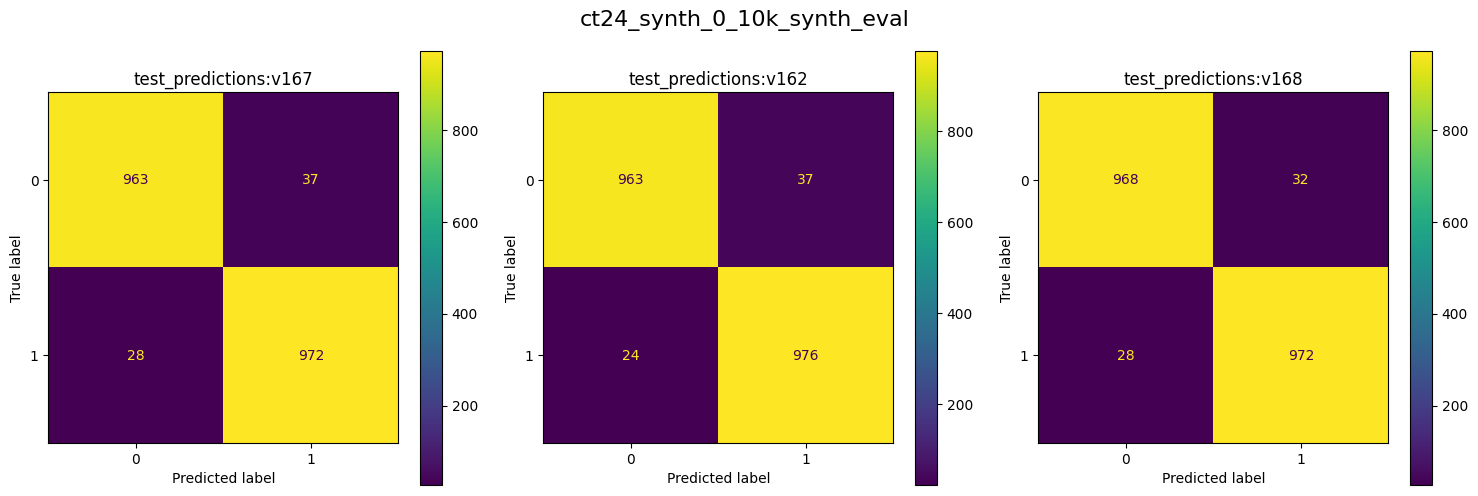

In [ ]:
plot_predictions(download_predictions("ct24_synth_0_10k_synth_eval"))
#plot_predictions(download_predictions("ct24_double_general_claim_eval", invert=invert))

In [ ]:
synth_test_df = pd.read_csv("../generate/data/pos_neg_prop_test_labelled.csv")

In [ ]:
misclassified_synth_test = [get_misclassified_samples(result_dict["predictions"], synth_test_df) for result_dict in predictions_ct24_synth[5]]

In [ ]:
misclassified_synth_test[0]

,context,Text,properties,class_label
2,"During a recent debate among fans, a discussio...",The claim that his defensive performance last ...,The claim should be about sports. The claim sh...,0
21,"During a recent lecture at the law school, the...",Roman law has influenced many contemporary leg...,The claim should be about law. The claim shoul...,0
50,Everyone keeps raving about these so-called sc...,Water freezes at 0 degrees Celsius.,The claim should be about science. The tone of...,0
69,"In a previous discussion, Professor Gardner sm...",If by trivial you mean government spending $25...,The claim should be about space. The claim sho...,1
103,Our discussion at the community center about p...,Did you realize that local ordinances prohibit...,The claim should be about law. The claim shoul...,1
...,...,...,...,...
1824,"During the team meeting, we covered recent sci...",It is widely known that goldfish can develop i...,The claim should be about science. The claim s...,0
1834,"In recent years, heated debates have erupted i...",Black hole event horizons are merely theoretic...,The claim should be about science. The claim s...,1
1886,At a town hall meeting focused on curriculum d...,Research indicates that traditional teaching m...,The claim should be about education. The claim...,1
1991,After reviewing the comments on the recent deb...,Racism is often used as a scapegoat for proble...,The claim should be about racism. The claim sh...,0


In [ ]:
#majority_misclassified_ct24 = intersect_misclassifications(misclassified_ct24, min_num_misclassified=1)
#majority_misclassified_ct24_double = intersect_misclassifications(misclassified_ct24_double, min_num_misclassified=1)

In [ ]:
#exclusive_ct24, exclusive_ct24_double = exclusive_misclassifications(majority_misclassified_ct24, majority_misclassified_ct24_double)

In [ ]:
#plot_misclassifications(exclusive_ct24, "CT24 exclusive misclassification distribution")
#plot_misclassifications(exclusive_ct24_double, "CT24 double exclusive misclassification distribution")